# Optimal restarts

A [Las Vegas algorithm](https://en.wikipedia.org/wiki/Las_Vegas_algorithm) is an algorithm with an *uncertain* runtime, but *certain* correctness.  In other words,  if such an algorithm halts, its output will be correct, but the time until it halts is a random variable.  Thus, the algorithm has a runtime distribution, which may or may not have a finite expectation.  Today, I will talk about a general *acceleration* strategies for such algorithms based on random restarts.

**Familiar example:** Quicksort.

**Synthetic example:** ???

**The random restart wrapper:**

The generic strategy for accelerating the algorithms will determine an optimal runtime time as a function of the algorithms runtime distribution, which for---the time being---we shall assume is known to the algorithm.

In [1]:
from arsenal import timelimit, Timeout, restore_random_state
def restart_acceleration(alg, policy):
    for seed in random_seeds():      # loop over an unbounded sequence of random seeds
        t = policy()
        try:
            # Run `alg` for `cap` seconds under a given random `seed`.  
            # If the run fails to halt in time, return `None`.
            with timelimit(t), restore_random_state(seed):
                return alg()            # if the algorithm halted, output result
        except Timeout:
            pass

The explicit control over random seeds is not required, but is nice to have when it is available.  Since we are working with algorithm, we will generally have control over the random seed.

if the algorithm halted within the chosen time limit, the wrapper also halts with the algorithm's result.
otherwise, the wrapper runs the algorithms again, hoping to get luckier.

When the runtime distribution is known, the optimal policy for runtime budgets is a fixed constant threshold! This is somewhat surprising - I will give a simple arugment for why it is true.  

When the runtime distribution is not known there exists a universal strategy, which retries under an universal sequence of runtime thresholds.

The original work is 
Luby, Sinclair, and Zuckerman (1993)
Optimal Speedup of Las Vegas Algorithms

TODO: Give refs to the better papers.

TODO: Tie in with sqrt-biased sampling algorithm. The simulation algorithms are very similar.  Here we only have one knob: the threshold; there we had a search distribution.

In [2]:
import numpy as np, pylab as pl, scipy.stats as st
from arsenal.maths import mean_confidence_interval
from scipy.integrate import quad
from arsenal import iterview
from arsenal.cache import memoize

@np.vectorize
def right_truncated_mean(R):
    "E[T | T <= R]"
    p = d.cdf(R)
    if p == 0: return np.inf
    [est, _] = quad(lambda x: x * d.pdf(x), 0, R) 
    return est / p

H = lambda t: d.pdf(t)/d.sf(t)   # hazard-rate function

# define a runtime distribution
d = st.lognorm(1)

m = d.mean()
s = d.std()
print(m, s)

1.6487212707001282 2.1611974158950877


In [3]:
def T(R):
    "Expected runtime with restart threshold `R`"
    p = d.cdf(R)
    return R * (1-p)/p + right_truncated_mean(R)

In [4]:
ts = np.linspace(0.1, m*2, 100)
Ts = np.array([T(r) for r in iterview(ts)])

100.0% (100/100) [====================================================] 00:00:03


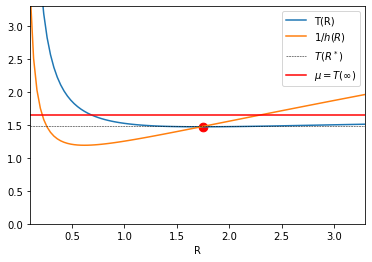

In [5]:
pl.plot(ts, Ts, label=r'T(R)')
pl.plot(ts, 1/H(ts), label=r'$1/h(R)$')     # inverse of the hazard-rate function
pl.scatter(ts[Ts.argmin()], [Ts.min()], marker='o', c='r', s=75)
pl.ylim(0, m*2); pl.xlim(ts.min(), ts.max())

rstar = ts[Ts.argmin()]
Tstar = d.sf(rstar) / d.pdf(rstar)   # analytical-ish
pl.axhline(Tstar, c='k', lw=0.5, linestyle='--', label=r'$T(R^*)$');
pl.axhline(d.mean(), c='r', label=r'$\mu = T(\infty)$')
pl.legend(loc='best'); pl.xlabel('R');

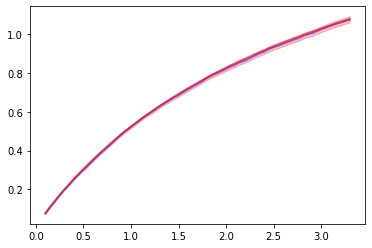

In [6]:
# test that the right-truncated mean estimate matches rejection sampling
N = 10000
S = d.rvs(N)

def simulate(t):
    return mean_confidence_interval(S[S <= t])

mi,lb,ub = zip(*[simulate(t) for t in ts])
pl.fill_between(ts, lb, ub, color='r', alpha=0.25)
pl.plot(ts, mi, c='b', alpha=0.5, lw=2)
pl.plot(ts, right_truncated_mean(ts), c='r', lw=2, alpha=0.5);

100.0% (100/100) [====================================================] 00:00:18


(0.1, 3.2974425414002564)

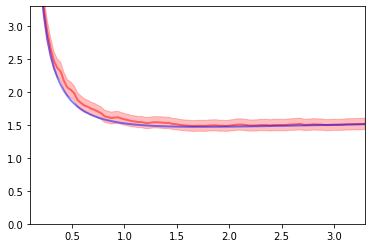

In [11]:
def _simulate(R, seed):
    "simulate capped-restart distribution"
    with restore_random_state(seed):
        total = 0.0
        while True:
            r = d.rvs()
            total += min(r, R)            
            if r <= R:
                return total

def simulate(R, seeds):
    S = [_simulate(R, seed) for seed in seeds]
    return mean_confidence_interval(S)

M = 1000
seeds = [int(np.random.randint(0, 2**32)) for _ in range(M)]

mi,lb,ub = zip(*[simulate(t, seeds) for t in iterview(ts)])
pl.fill_between(ts, lb, ub, color='r', alpha=0.25)
pl.plot(ts, mi, c='r', alpha=0.5, lw=2)
pl.plot(ts, Ts, c='b', alpha=0.5, lw=2); pl.ylim(0, m*2)
pl.xlim(ts.min(), ts.max())

## Universal strategy

In [8]:
from arsenal.iterextras import take
def universal(scale, base):
    assert base > 1
    i = 0
    while True:
        i += 1
        for j in range(i):
            yield scale * base**j

print(list(take(15, universal(1, 2))))
print(list(take(15, universal(.1, 1.1))))

[1, 1, 2, 1, 2, 4, 1, 2, 4, 8, 1, 2, 4, 8, 16]
[0.1, 0.1, 0.11000000000000001, 0.1, 0.11000000000000001, 0.12100000000000002, 0.1, 0.11000000000000001, 0.12100000000000002, 0.13310000000000005, 0.1, 0.11000000000000001, 0.12100000000000002, 0.13310000000000005, 0.14641000000000004]


In [9]:
def _simulate(policy, seed):
    with restore_random_state(seed):
        total = 0.0
        while True:
            r = d.rvs()
            R = policy()
            total += min(r, R)
            if r <= R:
                return total

p = universal(0.01, 2)
print('universal:',
    d.mean(),
    _simulate(p.__next__, seed=0)
)
print('baseline: ', d.mean(), d.std())

universal: 1.6487212707001282 0.9578485648382067
baseline:  1.6487212707001282 2.1611974158950877


## Derivation

The following recursive definition of the expected value under the policy $\tau$ is essentially a two-state MDP (a terminal and non-terminal state). The analysis is agnostic to whether $\tau$ is discrete or continuous.

$$
v = \mathbb{E}_p[ \min(t, \tau) ]    +   (1 - p( t \le \tau)) \cdot (overhead + \tau + v)
%           immediate cost        prob retry      retry      retry
%            of the run                         overhead
$$

where overhead $\ge 0$ is a known, constant restart-overhead penalty.

Solving the recurrence for v, we obtain

$$
\begin{align}
  v &= \mathbb{E}_p[t |t \le \tau] + \frac{1-p(t \le \tau)}{p(t \le \tau)} \cdot (overhead + \tau).
\end{align}
$$

Since this is an MDP, it follows that the optimal policy is pure and stationary (i.e., deterministic and fixed over time).

The optimal \tau can be computed by enumeration in the discrete case.
In the continuous case, it can be computed in "the usual way" (i.e.,
by solving for \tau such that the gradient of v(tau) is equal to zero;
and check the sign of the second derivative). The general form is
nonconvex.

$$
\frac{\partial v}{\partial \tau}
= \frac{1-p(t \le \tau)}{p(t \le \tau)} - \frac{p(\tau)}{p(t \le \tau)} \cdot v
$$

Solve for $\tau$ such that the derivative is zero.
$$
\begin{align}
\frac{\partial v}{\partial \tau} &= 0 \\
\frac{1-p(t \le \tau)}{p(t \le \tau)} &= \frac{p(\tau)}{p(t \le \tau)} \cdot \left( \mathbb{E}_p[t |t \le \tau] + \frac{1-p(t \le \tau)}{p(t \le \tau)} \cdot (overhead + \tau) \right) \\
\frac{1-p(t \le \tau)}{p(\tau)} &= \mathbb{E}_p[t |t \le \tau] + \frac{1-p(t \le \tau)}{p(t \le \tau)} \cdot (overhead + \tau)
\end{align}
$$

Remarks:

The optimally capped expectation (as well as higher-order moments) are always finite - even when the underlying RTD puts positive probability on nontermination.